In [4]:
import os
from dotenv import load_dotenv
from client import openai_client
from runners.standard_run import std_run
from runners.streaming_run import streaming_run

load_dotenv()

client = openai_client.create()

assistant = client.beta.assistants.create(
  name="Math Tutor",
  instructions="You are a personal math tutor. Write and run code to answer math questions.",
  model=os.getenv("MODEL"),
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I need to solve the equation `3x + 11 = 14`. Can you help me?"
)

In [3]:
assistant.model

'gpt-3.5-turbo'

When the user has added all of the necessary information/messages to the thread you must run the thread to provide them with results.

You can run a thread using it's id as well as the assistant id, like this:

In [6]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
  #model = "gpt-3.5-turbo" # By default the model defined in the assistant will be used. You can, however, overwrite it here.
  instructions = "Please address the user as SISTCA student." # This parameter is optional
)

During it's lifecycle, a run can have multiple lifecycles:

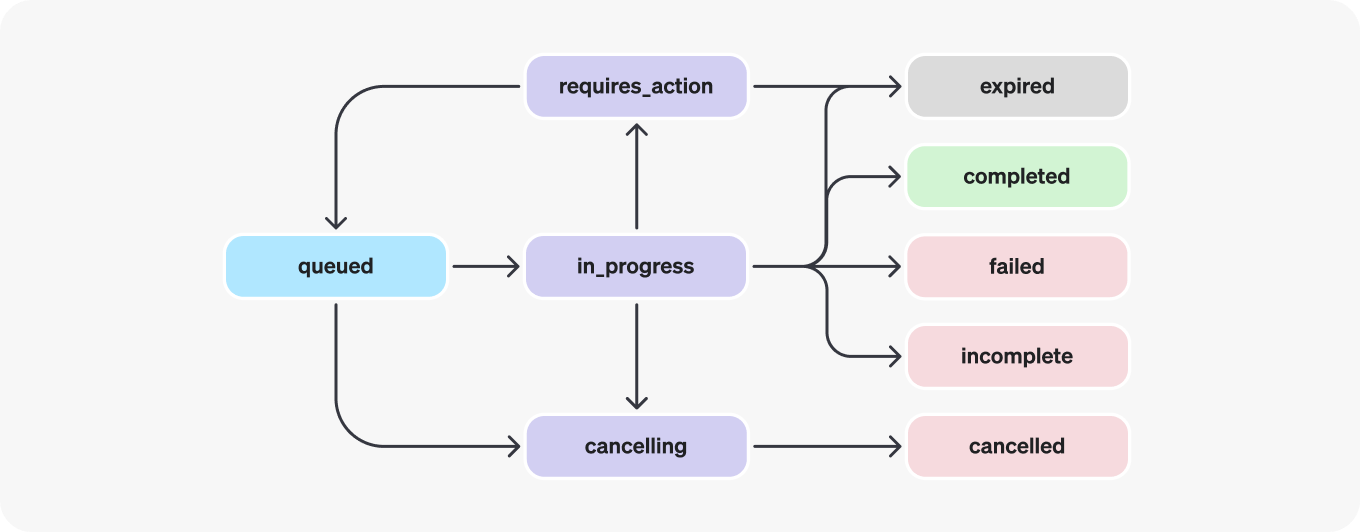
[https://platform.openai.com/docs/assistants/how-it-works/runs-and-run-steps]

Therefore, we must check for it's completion.

In [ ]:
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
else:
  print(run.status)

In order to yield any results, an assistant's thread must be run. This is to say that whenever you're working with the assistant functionality you must have a runner function. 

Due to the fact that we will be exploring other types of assistant's, and as a way of not repeating this code multiple times, we will export as the following function:

In [8]:
def std_run (thread_id, assistant_id, client):
    run = client.beta.threads.runs.create_and_poll(
        thread_id = thread_id,
        assistant_id = assistant_id,
        instructions = "Please address the user as SISTCA student."
    )   

    if run.status == 'completed': 
        messages = client.beta.threads.messages.list(thread_id = thread_id)
        print(messages.data[0].content[0].text.value)
    else:
        print(run.status)


If you have used ChatGPT before you may have noticed that the output is not returned all at once, like it is here, but rather gradually, in real time.

We can achieve this same effect by using a different type of runner, the streaming run.

Likewise, we will export it as a function for better reusability.

In [9]:
from typing_extensions import override
from openai import AssistantEventHandler
 
# First, we create a EventHandler class to define
# how we want to handle the events in the response stream.
 
class EventHandler(AssistantEventHandler):    
  @override
  def on_text_created(self, text) -> None:
    print(f"\nassistant > ", end="", flush=True)
      
  @override
  def on_text_delta(self, delta, snapshot):
    print(delta.value, end="", flush=True)
      
  def on_tool_call_created(self, tool_call):
    print(f"\nassistant > {tool_call.type}\n", flush=True)
  
  def on_tool_call_delta(self, delta, snapshot):
    if delta.type == 'code_interpreter':
      if delta.code_interpreter.input:
        print(delta.code_interpreter.input, end="", flush=True)
      if delta.code_interpreter.outputs:
        print(f"\n\noutput >", flush=True)
        for output in delta.code_interpreter.outputs:
          if output.type == "logs":
            print(f"\n{output.logs}", flush=True)
 
# Then, we use the `stream` SDK helper 
# with the `EventHandler` class to create the Run 
# and stream the response.
 
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Please address the user as SISTCA student.",
  event_handler=EventHandler(),
) as stream:
  stream.until_done()

# Function Calling

Whenever your assistant calls a function, the runner will enter a 'required_action' state. That is, for each function call you must specify what should be done. As such runners will handle function calls and define what the output will be.

In [25]:
# We start by creating an array to store the tool outputs
tool_outputs = []

In [26]:
#ESTE EXCERTO ESTÁ AQUI A TÍTULO DE TESTE!!!!
from functions import get_location_id, get_weather_data
import json

assistant = client.beta.assistants.create(
    instructions="You are a weather bot. Use the provided functions to answer questions.",
    model="gpt-3.5-turbo",
    tools=[
        {
            "type": "function",
            "function": {
                "name": "get_weather_data",
                "description": "Get the current weather forecast for the specified location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "City or region for which to get the weather forecast",
                        }
                    },
                    "required": ["location"]
                }
            }
        }
    ]
)


thread = client.beta.threads.create()

#Define the location name
location_name = "Lisboa"

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=f"How is the weather today in {location_name}?",
)

run = client.beta.threads.runs.create_and_poll(
        thread_id = thread.id,
        assistant_id = assistant.id
    )   



In [27]:
# We then check if a run is trying to call a tool and if so, we act accordingly
for tool in run.required_action.submit_tool_outputs.tool_calls:
    if tool.function.name == "get_weather_data":

        # let's start by checking the content of the tool call
        print(tool.function)

Function(arguments='{"location":"Lisboa"}', name='get_weather_data')


The assistant wants to call the get_weather_data function using the value "Lisboa" as the location argument.

Therefore, we will make the runner do exactly that:

In [28]:
# First, call the get_location_id function to get the location ID for the location argument in the tool call
location_id = get_location_id(json.loads(tool.function.arguments)["location"])
print(location_id)

1110600


In [29]:
# Now, knowing the location ID, we can call the get_weather_data function to get the weather data for the location
forecast = get_weather_data(location_id)
print(forecast)

{'precipitaProb': '0.0', 'tMin': '12.9', 'tMax': '20.4', 'predWindDir': 'NW', 'idWeatherType': 3, 'classWindSpeed': 2, 'longitude': '-9.1286', 'forecastDate': '2024-05-17', 'latitude': '38.7660'}


In [30]:
# Finally, we submit the output of the get_weather_data function to the run by appending an "output" key to the output array
tool_outputs.append({"tool_call_id": tool.id,
                    "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                    })

Having defined the tool outputs we must now add them to the runner so that our assistant can use them to answer our initial question.

In [31]:
if tool_outputs:
    try:
        run = client.beta.threads.runs.submit_tool_outputs_and_poll(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )
        print("Tool outputs submitted successfully.")
    except Exception as e:
        print("Failed to submit tool outputs:", e)
else:
    print("No tool outputs to submit.")

Tool outputs submitted successfully.


We then check for the run completion and display the output message:

In [33]:
if run.status == 'completed':
    messages = client.beta.threads.messages.list(thread_id=thread.id)
    print(messages.data[0].content[0].text.value)
else:
    print(run.status)

The weather in Lisboa today is expected to have a maximum temperature of 20.4°C and a minimum temperature of 12.9°C with 0.0% probability of rain.


The updated runner with the tool call handling code will look like this:


In [ ]:
def std_run (thread_id, assistant_id, client):
    run = client.beta.threads.runs.create_and_poll(
        thread_id = thread_id,
        assistant_id = assistant_id,
        instructions = "Please address the user as SISTCA student."
    )   

    if run.status == 'completed': 

        messages = client.beta.threads.messages.list(
            thread_id = thread_id
        )

        # This code acts upon the presence of image files when using code interpreter
        if messages.data[0].content[0].type == 'image_file':
            return(messages.data[0].content[0].image_file.file_id)
        else:
            print(run.status)

        return(messages.data[0].content[0].text.value)        
    
    # The following code is used to handle tool/function calls

    # Preparing tool outputs
    tool_outputs = []
    for tool in run.required_action.submit_tool_outputs.tool_calls:
        if tool.function.name == "get_weather_data":
            location_id = get_location_id(json.loads(tool.function.arguments)["location"])
            forecast = get_weather_data(location_id)
            tool_outputs.append({"tool_call_id": tool.id,
                                "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                                })

    # Submitting tool outputs and polling for completion status
    if tool_outputs:
        try:
            run = client.beta.threads.runs.submit_tool_outputs_and_poll(
                thread_id=thread_id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )
            print("Tool outputs submitted successfully.")
        except Exception as e:
            print("Failed to submit tool outputs:", e)
    else:
        print("No tool outputs to submit.")

    # Retrieving messages after tool output submission
    if run.status == 'completed':
        messages = client.beta.threads.messages.list(thread_id=thread_id)
        print(messages.data[0].content[0].text.value)
    else:
        print(run.status)

Using the same logic we can also stream the response in the runner. However, since function calling uses different events that can conflict we the previously defined ones, instead of updating the streaming_run function we will create a new one.

In [ ]:
def streaming_run_fc (thread_id, assistant_id, client):

    class EventHandler(AssistantEventHandler):
        @override
        def on_event(self, event):

            # Retrieve events that are denoted with 'requires_action'
            # since these will have our tool_calls
            
            if event.event == 'thread.run.requires_action':
                run_id = event.data.id  # Retrieve the run ID from the event data
                self.handle_requires_action(event.data, run_id)
    
        def handle_requires_action(self, data, run_id):
            tool_outputs = []
            
            for tool in data.required_action.submit_tool_outputs.tool_calls:
                if tool.function.name == "get_weather_data":
                    location_id = get_location_id(json.loads(tool.function.arguments)["location"])
                    forecast = get_weather_data(location_id)
                    tool_outputs.append({"tool_call_id": tool.id,
                                        "output": f"Rain probability: {forecast['precipitaProb']}, Max temperature: {forecast['tMin']}, Min temperature: {forecast['tMax']}"
                                        })
            
            # Submit all tool_outputs at the same time
            self.submit_tool_outputs(tool_outputs, run_id)
    
        def submit_tool_outputs(self, tool_outputs, run_id):
            # Use the submit_tool_outputs_stream helper
            with client.beta.threads.runs.submit_tool_outputs_stream(
                thread_id=self.current_run.thread_id,
                run_id=self.current_run.id,
                tool_outputs=tool_outputs,
                event_handler=EventHandler(),
            ) as stream:
                for text in stream.text_deltas:
                    print(text, end="", flush=True)
                print()
    
    
    with client.beta.threads.runs.stream(
        thread_id=thread_id,
        assistant_id=assistant_id,
        event_handler=EventHandler()
    ) as stream:
        stream.until_done()

# Code Interpreter

For the code interpreter, the runner must check wether that, when a run is completed, an image file is present in the response and, if so, return it.

In [ ]:
if messages.data[0].content[0].type == 'image_file':
    return(messages.data[0].content[0].image_file.file_id)